<a href="https://colab.research.google.com/github/shaghayegh5ghasemi/supervised_fuzzy_clustering/blob/main/Supervised_Fuzzy_Clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np


Files already downloaded and verified
Files already downloaded and verified


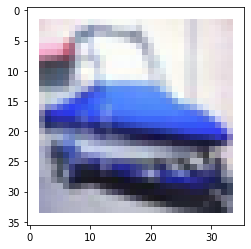

144


In [101]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# load data
trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = DataLoader(trainset, batch_size=100, shuffle=True, num_workers=2)

testset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = DataLoader(testset, batch_size=100, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# plot the image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy() # convert from tensor
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# add padding to right, top, botton with width = 2 and value = 1
def add_padding(img):
  npimg = img.numpy()
  padded_img = np.ones((3, 36, 36))
  padded_img[0:3, 2:34, 2:34] = npimg
  tensor_padded_img = torch.from_numpy(padded_img)
  return tensor_padded_img

# extract 3x3 window from 3x36x36 img => we have 12 3x3x3 images made from each individual image in dataset
def make_window(img, label):
  width = 36
  height = 36
  window_lists = []
  npimg = img.numpy()
  row = 0
  column = 0
  while(row < width):
    while(column < height):
      mini_tensor = torch.from_numpy(npimg[0:3, row:row+3, column:column+3])
      window_lists.append((mini_tensor, label))
      column = column + 3
    column = 0
    row = row + 3
  return window_lists


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# for i in range(100): 
#     if labels[i] == 9: 
#       print(images[i])
#       #imshow(torchvision.utils.make_grid(images[i]))
#       print(' '.join('%5s' % classes[labels[i]]))

img = add_padding(images[0])
lists = make_window(img)
imshow(torchvision.utils.make_grid(img))
print(len(lists))
